In [1]:
#Arellano’s [Are08] model of sovereign default.
#Source: QuantEcon
#Source link: https://julia.quantecon.org/multi_agent_models/arellano.html

In [5]:
using Pkg
Pkg.add(["LinearAlgebra", "Statistics", "LaTeXStrings", "Parameters", "QuantEcon", "DataFrames", "Plots","Random" ])


using LinearAlgebra, Statistics
using LaTeXStrings, Parameters, QuantEcon, DataFrames, Plots, Random

    Updating registry at `C:\Users\sigma\.julia\registries\General.toml`
   Resolving package versions...
    Updating `C:\Users\sigma\.julia\environments\v1.8\Project.toml`
  [d96e819e] + Parameters v0.12.3
  [37e2e46d] + LinearAlgebra
  [9a3f8284] + Random
  No Changes to `C:\Users\sigma\.julia\environments\v1.8\Manifest.toml`


In [6]:
function ArellanoEconomy(;β = .953,
                          γ = 2.,
                          r = 0.017,
                          ρ = 0.945,
                          η = 0.025,
                          θ = 0.282,
                          ny = 21,
                          nB = 251)

    # create grids
    Bgrid = collect(range(-.4, .4, length = nB))
    mc = tauchen(ny, ρ, η)
    Π = mc.p
    ygrid = exp.(mc.state_values)
    ydefgrid = min.(.969 * mean(ygrid), ygrid)

    # define value functions
    # notice ordered different than Python to take
    # advantage of column major layout of Julia)
    vf = zeros(nB, ny)
    vd = zeros(1, ny)
    vc = zeros(nB, ny)
    policy = zeros(nB, ny)
    q = ones(nB, ny) .* (1 / (1 + r))
    defprob = zeros(nB, ny)

    return (β = β, γ = γ, r = r, ρ = ρ, η = η, θ = θ, ny = ny,
            nB = nB, ygrid = ygrid, ydefgrid = ydefgrid,
            Bgrid = Bgrid, Π = Π, vf = vf, vd = vd, vc = vc,
            policy = policy, q = q, defprob = defprob)
end

u(ae, c) = c^(1 - ae.γ) / (1 - ae.γ)

function one_step_update!(ae,
                          EV,
                          EVd,
                          EVc)

    # unpack stuff
    @unpack β, γ, r, ρ, η, θ, ny, nB = ae
    @unpack ygrid, ydefgrid, Bgrid, Π, vf, vd, vc, policy, q, defprob = ae
    zero_ind = searchsortedfirst(Bgrid, 0.)

    for iy in 1:ny
        y = ae.ygrid[iy]
        ydef = ae.ydefgrid[iy]

        # value of being in default with income y
        defval = u(ae, ydef) + β * (θ * EVc[zero_ind, iy] + (1-θ) * EVd[1, iy])
        ae.vd[1, iy] = defval

        for ib in 1:nB
            B = ae.Bgrid[ib]

            current_max = -1e14
            pol_ind = 0
            for ib_next=1:nB
                c = max(y - ae.q[ib_next, iy]*Bgrid[ib_next] + B, 1e-14)
                m = u(ae, c) + β * EV[ib_next, iy]

                if m > current_max
                    current_max = m
                    pol_ind = ib_next
                end

            end

            # update value and policy functions
            ae.vc[ib, iy] = current_max
            ae.policy[ib, iy] = pol_ind
            ae.vf[ib, iy] = defval > current_max ? defval : current_max
        end
    end
end

function compute_prices!(ae)
    # unpack parameters
    @unpack β, γ, r, ρ, η, θ, ny, nB = ae

    # create default values with a matching size
    vd_compat = repeat(ae.vd, nB)
    default_states = vd_compat .> ae.vc

    # update default probabilities and prices
    copyto!(ae.defprob, default_states * ae.Π')
    copyto!(ae.q, (1 .- ae.defprob) / (1 + r))
    return
end

function vfi!(ae; tol = 1e-8, maxit = 10000)

    # unpack stuff
    @unpack β, γ, r, ρ, η, θ, ny, nB = ae
    @unpack ygrid, ydefgrid, Bgrid, Π, vf, vd, vc, policy, q, defprob = ae
    Πt = Π'

    # Iteration stuff
    it = 0
    dist = 10.

    # allocate memory for update
    V_upd = similar(ae.vf)

    while dist > tol && it < maxit
        it += 1

        # compute expectations for this iterations
        # (we need Π' because of order value function dimensions)
        copyto!(V_upd, ae.vf)
        EV = ae.vf * Πt
        EVd = ae.vd * Πt
        EVc = ae.vc * Πt

        # update value function
        one_step_update!(ae, EV, EVd, EVc)

        # update prices
        compute_prices!(ae)

        dist = maximum(abs(x - y) for (x, y) in zip(V_upd, ae.vf))

        if it % 25 == 0
            println("Finished iteration $(it) with dist of $(dist)")
        end
    end
end

function QuantEcon.simulate(ae,
                            capT = 5000;
                            y_init = mean(ae.ygrid),
                            B_init = mean(ae.Bgrid),
                            )

    # get initial indices
    zero_index = searchsortedfirst(ae.Bgrid, 0.)
    y_init_ind = searchsortedfirst(ae.ygrid, y_init)
    B_init_ind = searchsortedfirst(ae.Bgrid, B_init)

    # create a QE MarkovChain
    mc = MarkovChain(ae.Π)
    y_sim_indices = simulate(mc, capT + 1; init = y_init_ind)

    # allocate and fill output
    y_sim_val = zeros(capT+1)
    B_sim_val, q_sim_val = similar(y_sim_val), similar(y_sim_val)
    B_sim_indices = fill(0, capT + 1)
    default_status = fill(false, capT + 1)
    B_sim_indices[1], default_status[1] = B_init_ind, false
    y_sim_val[1], B_sim_val[1] = ae.ygrid[y_init_ind], ae.Bgrid[B_init_ind]

    for t in 1:capT
        # get today's indexes
        yi, Bi = y_sim_indices[t], B_sim_indices[t]
        defstat = default_status[t]

        # if you are not in default
        if !defstat
            default_today = ae.vc[Bi, yi] < ae.vd[yi]

            if default_today
                # default values
                default_status[t] = true
                default_status[t + 1] = true
                y_sim_val[t] = ae.ydefgrid[y_sim_indices[t]]
                B_sim_indices[t + 1] = zero_index
                B_sim_val[t+1] = 0.
                q_sim_val[t] = ae.q[zero_index, y_sim_indices[t]]
            else
                default_status[t] = false
                y_sim_val[t] = ae.ygrid[y_sim_indices[t]]
                B_sim_indices[t + 1] = ae.policy[Bi, yi]
                B_sim_val[t + 1] = ae.Bgrid[B_sim_indices[t + 1]]
                q_sim_val[t] = ae.q[B_sim_indices[t + 1], y_sim_indices[t]]
            end

        # if you are in default
        else
            B_sim_indices[t + 1] = zero_index
            B_sim_val[t+1] = 0.
            y_sim_val[t] = ae.ydefgrid[y_sim_indices[t]]
            q_sim_val[t] = ae.q[zero_index, y_sim_indices[t]]

            # with probability θ exit default status
            default_status[t + 1] = rand() ≥ ae.θ
        end
    end

    return (y_sim_val[1:capT], B_sim_val[1:capT], q_sim_val[1:capT],
            default_status[1:capT])
end

In [7]:
using DataFrames, Plots

In [8]:
ae = ArellanoEconomy(β = .953,     # time discount rate
                     γ = 2.,       # risk aversion
                     r = 0.017,    # international interest rate
                     ρ = .945,     # persistence in output
                     η = 0.025,    # st dev of output shock
                     θ = 0.282,    # prob of regaining access
                     ny = 21,      # number of points in y grid
                     nB = 251)     # number of points in B grid

# now solve the model on the grid.
vfi!(ae)

Finished iteration 25 with dist of 0.3424484168091375
Finished iteration 50 with dist of 0.09820394074288075
Finished iteration 75 with dist of 0.02915866229151476
Finished iteration 100 with dist of 0.008729266837651295
Finished iteration 125 with dist of 0.002618400938121823
Finished iteration 150 with dist of 0.0007857709211727126
Finished iteration 175 with dist of 0.00023583246008485048
Finished iteration 200 with dist of 7.078195654131036e-5
Finished iteration 225 with dist of 2.1244388765495614e-5
Finished iteration 250 with dist of 6.376267926100354e-6
Finished iteration 275 with dist of 1.913766855210497e-6
Finished iteration 300 with dist of 5.743961786208729e-7
Finished iteration 325 with dist of 1.723987352875156e-7
Finished iteration 350 with dist of 5.174360495630026e-8
Finished iteration 375 with dist of 1.5530289942944364e-8


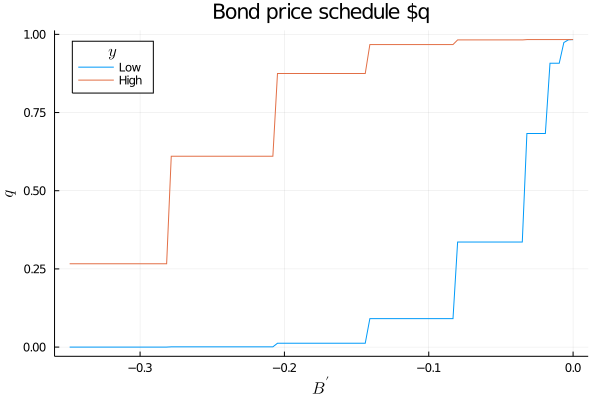

In [10]:
# create "Y High" and "Y Low" values as 5% devs from mean
high, low = 1.05 * mean(ae.ygrid), 0.95 * mean(ae.ygrid)
iy_high, iy_low = map(x -> searchsortedfirst(ae.ygrid, x), (high, low))

# extract a suitable plot grid
x = zeros(0)
q_low = zeros(0)
q_high = zeros(0)
for i in 1:ae.nB
    b = ae.Bgrid[i]
    if -0.35 ≤ b ≤ 0  # to match fig 3 of Arellano
        push!(x, b)
        push!(q_low, ae.q[i, iy_low])
        push!(q_high, ae.q[i, iy_high])
    end
end

# generate plot
plot(x, q_low, label = "Low")
plot!(x, q_high, label = "High")
plot!(title = L"Bond price schedule $q(y, B^\prime)$",
      xlabel = L"B^\prime", ylabel = L"q", legend_title = L"y", legend = :topleft)

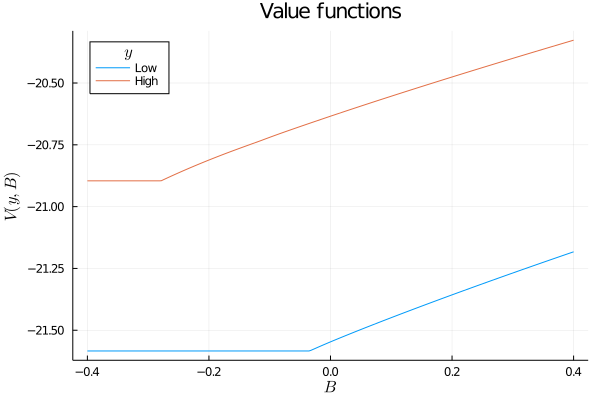

In [11]:
plot(ae.Bgrid, ae.vf[:, iy_low], label = "Low")
plot!(ae.Bgrid, ae.vf[:, iy_high], label = "High")
plot!(xlabel = L"B", ylabel = L"V(y,B)", title = "Value functions",
      legend_title=L"y", legend = :topleft)

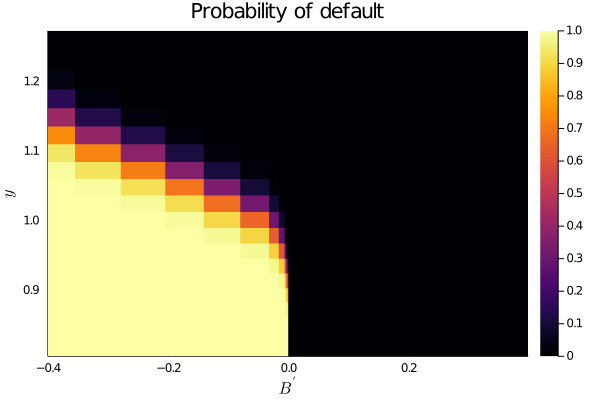

In [12]:
heatmap(ae.Bgrid[1:end-1],
    ae.ygrid[2:end],
    reshape(clamp.(vec(ae.defprob[1:end - 1, 1:end - 1]), 0, 1), 250, 20)')
plot!(xlabel = L"B^\prime", ylabel = L"y", title = "Probability of default",
    legend = :topleft)

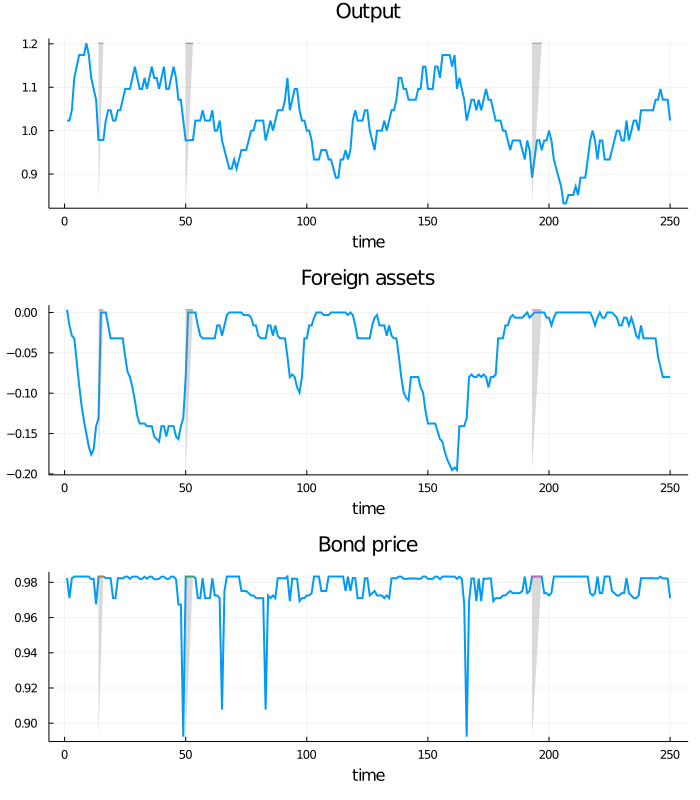

In [13]:
using Random
# set random seed for consistent result
Random.seed!(348938)

# simulate
T = 250
y_vec, B_vec, q_vec, default_vec = simulate(ae, T)

# find starting and ending periods of recessions
defs = findall(default_vec)
def_breaks = diff(defs) .> 1
def_start = defs[[true; def_breaks]]
def_end = defs[[def_breaks; true]]

y_vals = [y_vec, B_vec, q_vec]
titles = ["Output", "Foreign assets", "Bond price"]

plots = plot(layout = (3, 1), size = (700, 800))

# Plot the three variables, and for each each variable shading the period(s) of default
# in grey
for i in 1:3
    plot!(plots[i], 1:T, y_vals[i], title = titles[i], xlabel = "time", label = "", lw = 2)
    for j in 1:length(def_start)
        plot!(plots[i], [def_start[j], def_end[j]], fill(maximum(y_vals[i]), 2),
              fillrange = [extrema(y_vals[i])...], fcolor = :grey, falpha = 0.3, label = "")
    end
end

plot(plots)